<a href="https://colab.research.google.com/github/oussamaakdi/SP-500-Price-Predictions/blob/main/S%26P500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédiction des Prix et Actifs du S&P 500 grâce à du Machine Learning simple


In [162]:
pip install fredapi

In [163]:
pip install pmdarima

In [164]:
pip install tensorflow

# Imports


In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from fredapi import Fred
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


# Partie 1: Collecte et Préparation des Données


## Collecte des données

### 1. ^GSPC Data Extraction(S&P 500)





In [166]:
#les données historiques sur 5 ans
sp500 = yf.download('^GSPC', start='2019-01-01', end='2024-01-01', interval='1d')
sp500_flat = sp500.copy()  # pour préserver la structure originale
sp500_flat.columns = [col[0] for col in sp500.columns]
sp500 = sp500_flat.reset_index()


sp500


[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
0,2019-01-02,2510.030029,2510.030029,2519.489990,2467.469971,2476.959961,3733160000
1,2019-01-03,2447.889893,2447.889893,2493.139893,2443.959961,2491.919922,3858830000
2,2019-01-04,2531.939941,2531.939941,2538.070068,2474.330078,2474.330078,4234140000
3,2019-01-07,2549.689941,2549.689941,2566.159912,2524.560059,2535.610107,4133120000
4,2019-01-08,2574.409912,2574.409912,2579.820068,2547.560059,2568.110107,4120060000
...,...,...,...,...,...,...,...
1253,2023-12-22,4754.629883,4754.629883,4772.939941,4736.770020,4753.919922,3046770000
1254,2023-12-26,4774.750000,4774.750000,4784.720215,4758.450195,4758.859863,2513910000
1255,2023-12-27,4781.580078,4781.580078,4785.390137,4768.899902,4773.450195,2748450000
1256,2023-12-28,4783.350098,4783.350098,4793.299805,4780.979980,4786.439941,2698860000


<Axes: >

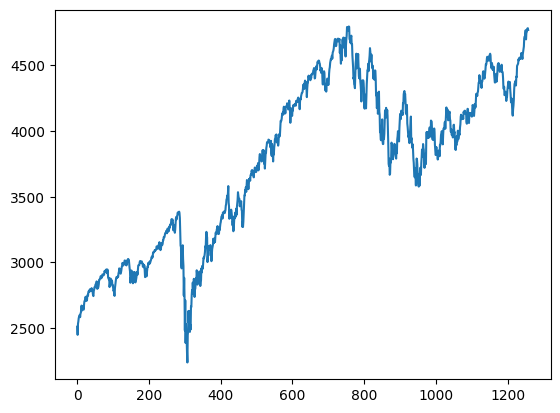

In [167]:
sp500['Adj Close'].plot()

### 2. VIX (Volatility Index)

In [168]:
#les données du VIX
vix = yf.download('^VIX', start='2019-01-01', end='2024-01-01', interval='1d')

vix = vix[['Close']].rename(columns={'Close': 'VIX'})
vix_flat = vix.copy()
vix_flat.columns = [col[0] for col in vix.columns]
vix = vix_flat.reset_index()
vix


[*********************100%***********************]  1 of 1 completed


,Date,VIX
0,2019-01-02,23.219999
1,2019-01-03,25.450001
2,2019-01-04,21.379999
3,2019-01-07,21.400000
4,2019-01-08,20.469999
...,...,...
1253,2023-12-22,13.030000
1254,2023-12-26,12.990000
1255,2023-12-27,12.430000
1256,2023-12-28,12.470000


<Axes: >

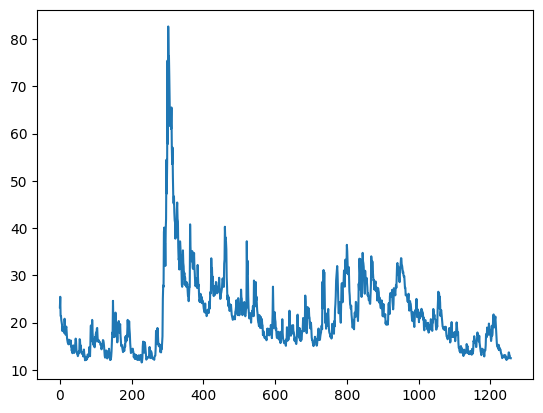

In [169]:
vix['VIX'].plot()

### 3. Taux d'intérêt (Fed Funds Rate)

In [170]:
# Clé API FRED
fred = Fred(api_key='bf789efaf2de29f1410841d297296d31')

rates = fred.get_series('FEDFUNDS', observation_start='2019-01-02', observation_end='2023-12-29')

# Convertion en DataFrame
rates_df = rates.reset_index()
rates_df.columns = ['Date', 'FedFundsRate']

rates_df = rates_df.set_index('Date').resample('D').ffill()

# Affichage des premières lignes
rates_df


,FedFundsRate
Date,
2019-01-01,2.40
2019-01-02,2.40
2019-01-03,2.40
2019-01-04,2.40
2019-01-05,2.40
...,...
2023-11-27,5.33
2023-11-28,5.33
2023-11-29,5.33


Vu qu'il s'agit des données mensuelles, les valeurs manquantes allant du 2023-12-02 jusqu'à 2023-12-29 seront remplies par 5.33

In [171]:
Date = sp500['Date'].copy()
rates_df = pd.merge(Date, rates_df, on='Date', how='left').fillna(5.33)
rates_df

,Date,FedFundsRate
0,2019-01-02,2.40
1,2019-01-03,2.40
2,2019-01-04,2.40
3,2019-01-07,2.40
4,2019-01-08,2.40
...,...,...
1253,2023-12-22,5.33
1254,2023-12-26,5.33
1255,2023-12-27,5.33
1256,2023-12-28,5.33


In [172]:
rates_df

,Date,FedFundsRate
0,2019-01-02,2.40
1,2019-01-03,2.40
2,2019-01-04,2.40
3,2019-01-07,2.40
4,2019-01-08,2.40
...,...,...
1253,2023-12-22,5.33
1254,2023-12-26,5.33
1255,2023-12-27,5.33
1256,2023-12-28,5.33


### 4. inflation




In [173]:
api_key = '2669IYGNWWU73XGL'

# URL pour l'indicateur d'inflation
url = f'https://www.alphavantage.co/query?function=INFLATION&apikey={api_key}'

# Récupération des données
response = requests.get(url)
data = response.json()

# Convertion en DataFrame
inflation_data = pd.DataFrame.from_dict(data['data'])
inflation_data['date'] = pd.to_datetime(inflation_data['date'])
inflation_data = inflation_data.rename(columns={'date':'Date','value':'inflation'})
inflation_data = inflation_data.iloc[:5,:]
inflation_data = inflation_data.set_index('Date').resample('D').ffill()

inflation_data


KeyError: 'data'

La fréquence des valeurs de l'inflation est annuelle donc les valeurs manquantes de 2023 seront égales à 4.11633838374488

In [ ]:
inflation_data = pd.merge(Date, inflation_data, on='Date', how='left').fillna(4.11633838374488)

### 5. PIB

In [175]:
gdp_data = fred.get_series('GDPC1', observation_start='2019-01-02',observation_end='2023-12-29')

# Convertion en DataFrame
gdp_df = gdp_data.reset_index()
gdp_df.columns = ['Date', 'RealGDP']

# ajout des valeurs manquantes du dernier trimestre de 2023
new_row = pd.DataFrame({'Date': ['2023-12-29'], 'RealGDP': [22960.600]})
df = pd.concat([gdp_df, new_row], ignore_index=True)

# Convertion de la colonne 'Date' en datetime pour garantir la cohérence
df['Date'] = pd.to_datetime(df['Date'])

# Tri du DataFrame par date
gdp_df = df.sort_values(by='Date').reset_index(drop=True)
gdp_df = gdp_df.set_index('Date').resample('D').ffill()

gdp_df


,RealGDP
Date,
2019-01-01,20431.641
2019-01-02,20431.641
2019-01-03,20431.641
2019-01-04,20431.641
2019-01-05,20431.641
...,...
2023-12-25,22960.600
2023-12-26,22960.600
2023-12-27,22960.600


### 6. Jointure des tables

In [176]:
merged_df = sp500.merge(vix, on='Date', how='left')
merged_df = merged_df.merge(rates_df, on='Date', how='left')
merged_df = merged_df.merge(gdp_df, on='Date', how='left')
df = merged_df.merge(inflation_data, on='Date', how='left')


In [177]:
df

,Date,Adj Close,Close,High,Low,Open,Volume,VIX,FedFundsRate,RealGDP,inflation
0,2019-01-02,2510.030029,2510.030029,2519.489990,2467.469971,2476.959961,3733160000,23.219999,2.40,20431.641,1.81221007526021
1,2019-01-03,2447.889893,2447.889893,2493.139893,2443.959961,2491.919922,3858830000,25.450001,2.40,20431.641,1.81221007526021
2,2019-01-04,2531.939941,2531.939941,2538.070068,2474.330078,2474.330078,4234140000,21.379999,2.40,20431.641,1.81221007526021
3,2019-01-07,2549.689941,2549.689941,2566.159912,2524.560059,2535.610107,4133120000,21.400000,2.40,20431.641,1.81221007526021
4,2019-01-08,2574.409912,2574.409912,2579.820068,2547.560059,2568.110107,4120060000,20.469999,2.40,20431.641,1.81221007526021
...,...,...,...,...,...,...,...,...,...,...,...
1253,2023-12-22,4754.629883,4754.629883,4772.939941,4736.770020,4753.919922,3046770000,13.030000,5.33,22960.600,4.116338
1254,2023-12-26,4774.750000,4774.750000,4784.720215,4758.450195,4758.859863,2513910000,12.990000,5.33,22960.600,4.116338
1255,2023-12-27,4781.580078,4781.580078,4785.390137,4768.899902,4773.450195,2748450000,12.430000,5.33,22960.600,4.116338
1256,2023-12-28,4783.350098,4783.350098,4793.299805,4780.979980,4786.439941,2698860000,12.470000,5.33,22960.600,4.116338


## Prétraitement des données

In [178]:
# pour garder une version des données d'origine
data = df.copy()

In [179]:
data

,Date,Adj Close,Close,High,Low,Open,Volume,VIX,FedFundsRate,RealGDP,inflation
0,2019-01-02,2510.030029,2510.030029,2519.489990,2467.469971,2476.959961,3733160000,23.219999,2.40,20431.641,1.81221007526021
1,2019-01-03,2447.889893,2447.889893,2493.139893,2443.959961,2491.919922,3858830000,25.450001,2.40,20431.641,1.81221007526021
2,2019-01-04,2531.939941,2531.939941,2538.070068,2474.330078,2474.330078,4234140000,21.379999,2.40,20431.641,1.81221007526021
3,2019-01-07,2549.689941,2549.689941,2566.159912,2524.560059,2535.610107,4133120000,21.400000,2.40,20431.641,1.81221007526021
4,2019-01-08,2574.409912,2574.409912,2579.820068,2547.560059,2568.110107,4120060000,20.469999,2.40,20431.641,1.81221007526021
...,...,...,...,...,...,...,...,...,...,...,...
1253,2023-12-22,4754.629883,4754.629883,4772.939941,4736.770020,4753.919922,3046770000,13.030000,5.33,22960.600,4.116338
1254,2023-12-26,4774.750000,4774.750000,4784.720215,4758.450195,4758.859863,2513910000,12.990000,5.33,22960.600,4.116338
1255,2023-12-27,4781.580078,4781.580078,4785.390137,4768.899902,4773.450195,2748450000,12.430000,5.33,22960.600,4.116338
1256,2023-12-28,4783.350098,4783.350098,4793.299805,4780.979980,4786.439941,2698860000,12.470000,5.33,22960.600,4.116338


#### Missing values

<Axes: >

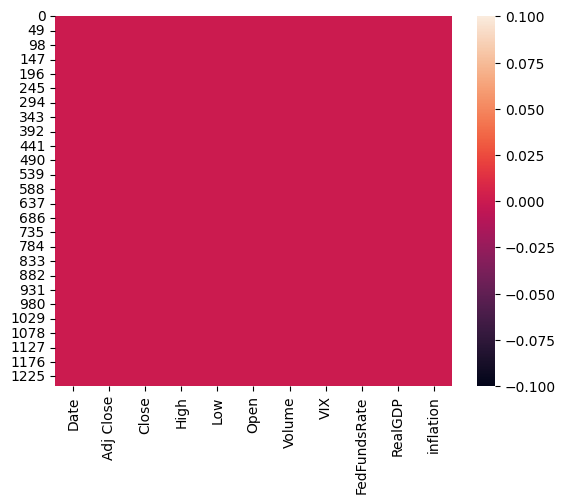

In [180]:
import seaborn as sns
sns.heatmap(data.isna())

In [181]:
data.isna().describe()

,Date,Adj Close,Close,High,Low,Open,Volume,VIX,FedFundsRate,RealGDP,inflation
count,1258,1258,1258,1258,1258,1258,1258,1258,1258,1258,1258
unique,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False
freq,1258,1258,1258,1258,1258,1258,1258,1258,1258,1258,1258


Il n'y a pas de valeurs manquantes dans la table data retenue

#### Analyse de la distribution de la variable dépendante Close

In [182]:
(data['Adj Close']==data['Close']).value_counts()

,count
True,1258


Les deux colonnes Adj Close et Close sont identiques, on garde seule la colonne Close

In [183]:
data=data.drop(columns=['Adj Close'])

<ipython-input-184-a99979ddcd24>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Close'])


<Axes: xlabel='Close', ylabel='Density'>

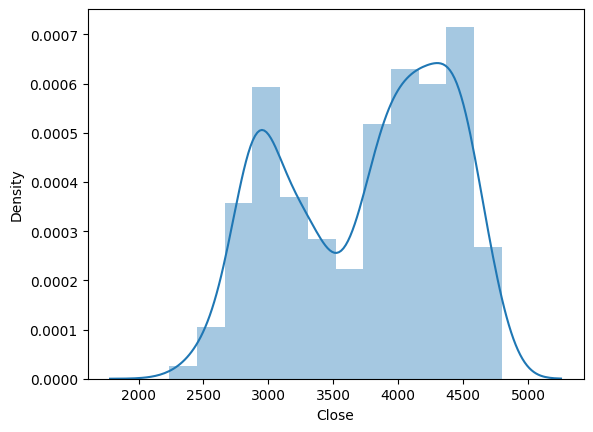

In [184]:
sns.distplot(data['Close'])

In [185]:
data['Close'].skew()

-0.29283113033205804

**Non identifiable à une distribution usuelle et présente une asymétrie**



--- Pour rendre la distribution plus symétrique on va appliquer une transformation logarithmique sur les variable de prix pour se retrouver avec des variables de type rendements logarithmiques (log-returns)

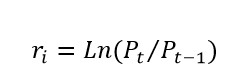



In [186]:
data['Log_Close'] = np.log(data['Close'] / data['Close'].shift(1))

<ipython-input-187-302536327295>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Log_Close'])


<Axes: xlabel='Log_Close', ylabel='Density'>

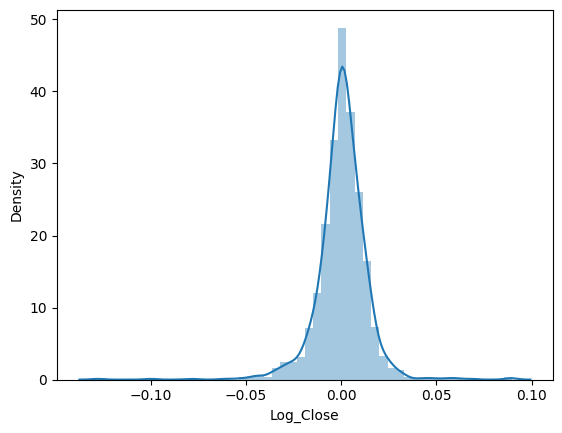

In [187]:
sns.distplot(data['Log_Close'])

In [188]:
data['Log_Close'].skew()

-0.831579185619946

Généralisation de la transformation aux variables de type prix : High/ Low/ Open/ RealGDP

In [189]:
data['Log_High'] = np.log(data['High'] / data['High'].shift(1))
data['Log_Low'] = np.log(data['Low'] / data['Low'].shift(1))
data['Log_Open'] = np.log(data['Open'] / data['Open'].shift(1))
data['Log_RealGDP'] = np.log(data['RealGDP'] / data['RealGDP'].shift(1))

<ipython-input-190-26699b62c75b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['High'])
<ipython-input-190-26699b62c75b>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Log_High'])
<ipython-input-190-26699b62c75b>:7: UserWarning: 

`distplot` is a deprecated function and will be r

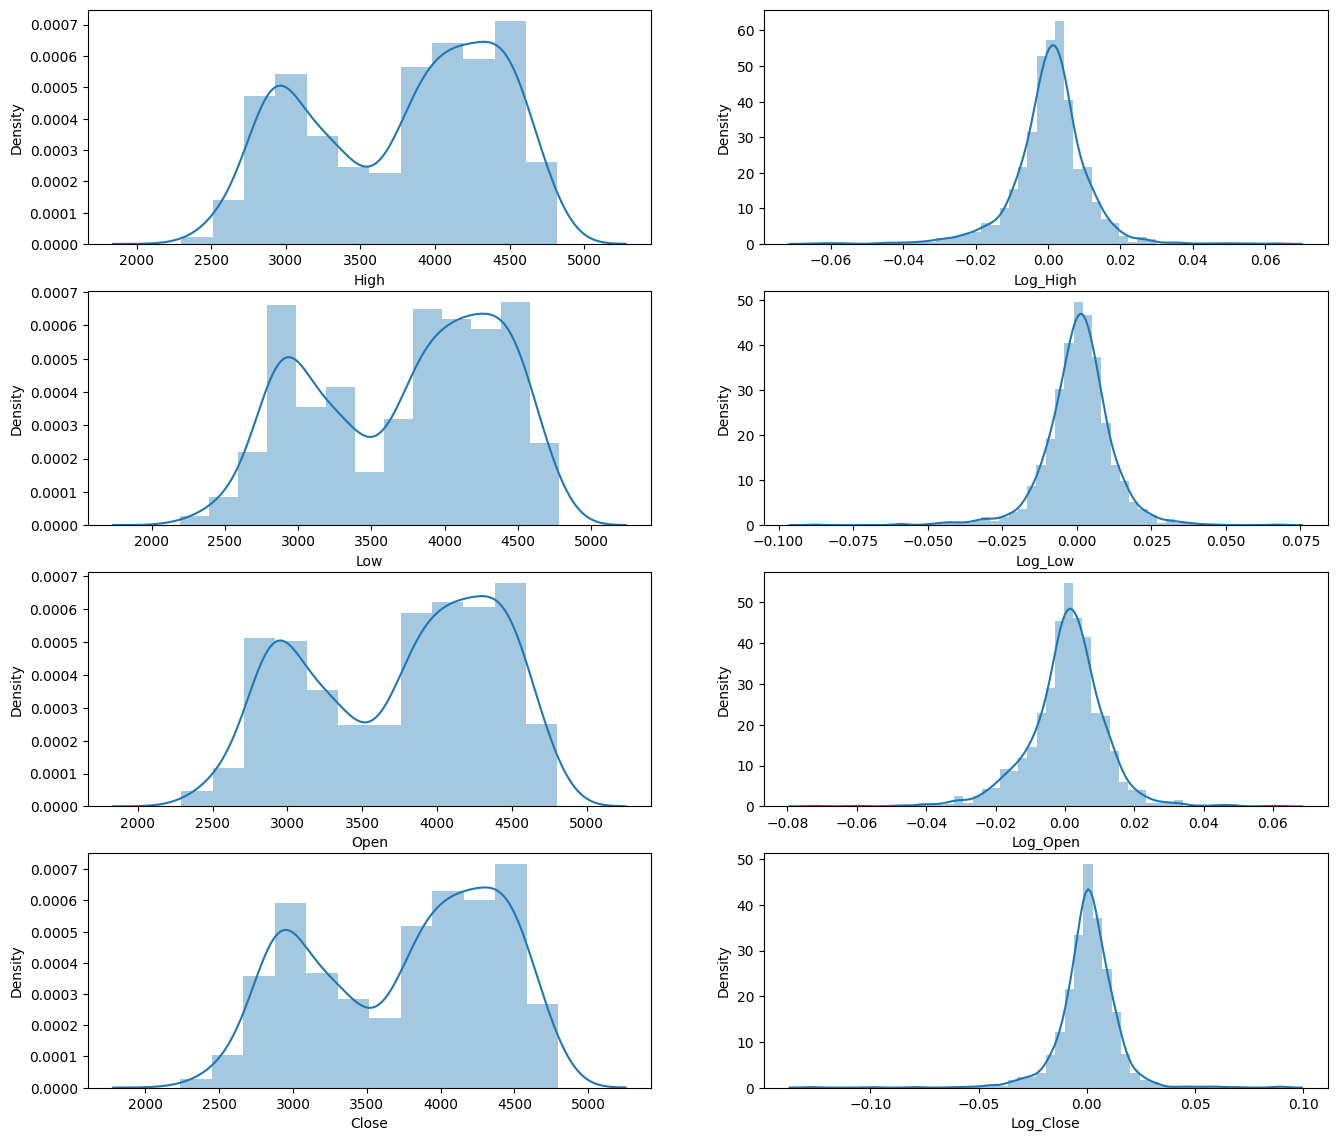

In [190]:
plt.figure(figsize=(16, 14))
plt.subplot(4, 2, 1)
sns.distplot(data['High'])
plt.subplot(4, 2, 2)
sns.distplot(data['Log_High'])
plt.subplot(4, 2, 3)
sns.distplot(data['Low'])
plt.subplot(4, 2, 4)
sns.distplot(data['Log_Low'])
plt.subplot(4, 2, 5)
sns.distplot(data['Open'])
plt.subplot(4, 2, 6)
sns.distplot(data['Log_Open'])
plt.subplot(4, 2, 7)
sns.distplot(data['Close'])
plt.subplot(4, 2, 8)
sns.distplot(data['Log_Close'])
plt.show()

#### Analyse de stationnarité (test ADF)

##### Test ADF (Augmented Dickey-Fuller)

Le **test ADF (Augmented Dickey-Fuller)** est une méthode statistique utilisée pour évaluer si une série temporelle est **stationnaire** ou non. Une série est dite stationnaire si ses propriétés statistiques (moyenne, variance et autocorrélation) ne changent pas au cours du temps, ce qui est une condition essentielle pour appliquer certains modèles statistiques, comme ARIMA.

###### **Principe du test :**
Le test ADF vérifie l’hypothèse nulle (\(H_0\)) selon laquelle la série possède une racine unitaire, ce qui signifie qu’elle est non stationnaire. Si l’hypothèse nulle est rejetée (\(p < 0.05\)), cela indique que la série est stationnaire.

###### **Interprétation des résultats :**
1. **Statistique ADF** : Indique la force de la stationnarité (plus elle est négative, plus la série est stationnaire).
2. **P-value** :
   - \(p < 0.05\) : La série est stationnaire (on rejette \(H_0\)).
   - \(p \geq 0.05\) : La série est non stationnaire (on ne rejette pas \(H_0\)).
3. **Valeurs critiques** : Aident à comparer la statistique ADF pour décider si la stationnarité est significative aux niveaux de 1%, 5% ou 10%.

###### **Conclusion :**
Le test ADF est un outil clé pour diagnostiquer la stationnarité d'une série temporelle, et il guide souvent les transformations nécessaires (différenciation, log-transformation, etc.) avant de procéder à une modélisation. Il est souvent complété par d'autres outils comme l'ACF et la PACF pour analyser la dépendance temporelle.

**Mise en oeuvre du test**

In [191]:
adf_result = adfuller(data['Log_Close'].dropna())

print(f"Statistique ADF : {adf_result[0]}")
print(f"P-value : {adf_result[1]}")
print("Valeurs critiques :", adf_result[4])

if adf_result[1] < 0.01:
    print("La série est stationnaire (rejette l'hypothèse nulle).")
else:
    print("La série n'est pas stationnaire (ne rejette pas l'hypothèse nulle).")


Statistique ADF : -10.50920875705528
P-value : 1.034999763346179e-18
Valeurs critiques : {'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}
La série est stationnaire (rejette l'hypothèse nulle).


**Résultat immédiat** : Pouvoir modéliser la série temporelle par une série de type ARIMA, en se basant sur la lecture graphique de ACF et PACF

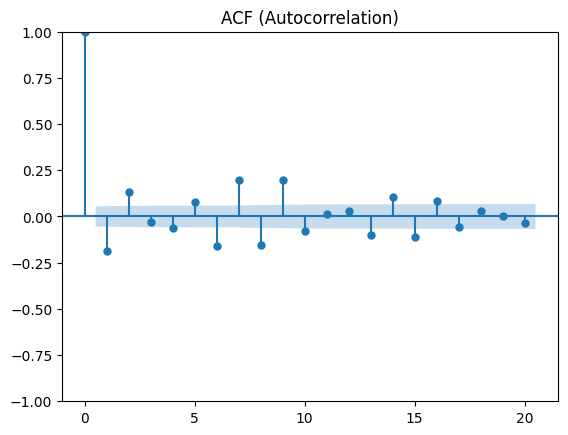

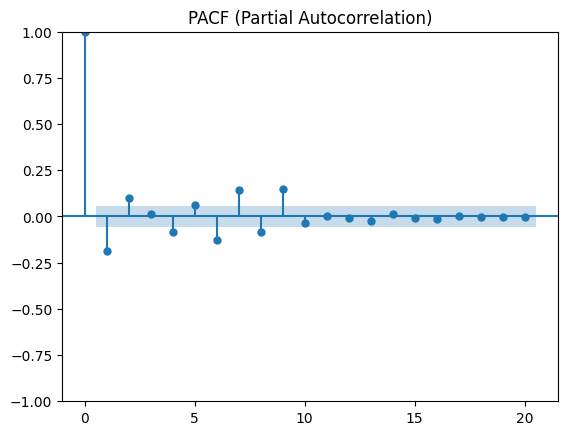

In [192]:
# l'ACF
plot_acf(data['Log_Close'].dropna(), lags=20)
plt.title("ACF (Autocorrelation)")
plt.show()

# la PACF
plot_pacf(data['Log_Close'].dropna(), lags=20, method='ywm')
plt.title("PACF (Partial Autocorrelation)")
plt.show()


##### Interprétation du PACF
Le PACF montre la corrélation partielle entre la série et ses décalages (lags) en éliminant l’effet des corrélations intermédiaires. Les barres qui dépassent les limites bleues indiquent des corrélations significatives.
Dans le graphique :
- Le lag 1 a une corrélation très forte.
- Quelques lags légèrement significatifs entre 2 et 10.
- Les lags supérieurs à 10 sont insignifiants.

##### Détermination des décalages temporels pertinents
- Inclure le lag 1 est essentiel pour capturer la dépendance immédiate.
- Les lags jusqu'à 10 peuvent être inclus pour modéliser des dépendances significatives.

##### Recommandation pour la modélisation
- Pour un modèle ARIMA, définissez le paramètre \(p\) à 10 (ou moins).
- Pour un modèle AR simple, inclure les 3 premiers lags est suffisant.


## Feature engineering

#### Création des variables Month, Day_of_week, Day_of_month

In [193]:
data['Month'] = data['Date'].dt.month

data['Day_of_Week'] = data['Date'].dt.day_name()

data['Day_of_Month'] = data['Date'].dt.day



#### moyenne mobile sur 10 jours glissants à partir de la variable Log_Close

In [194]:
data['10_Day_Moving_Avg'] = data['Log_Close'].rolling(window=10).mean()


##### **Remarque**: Pour les 9 premières lignes, la valeur sera NaN, car il faut au moins 10 observations pour calculer la moyenne mobile. La colonne 10_Day_Moving_Avg contiendra les moyennes calculées à partir du 10ème jour.

#### RSI (Relative Strength Index)

##### Relative Strength Index (RSI)

Le **RSI (Relative Strength Index)** est un oscillateur technique utilisé en trading pour mesurer la force des gains et des pertes récents sur une période donnée (généralement 14 jours). Il permet d'évaluer si un actif est en **surachat** ou **survente**.

###### **Formule du RSI** :
1. Calcul du RS (Relative Strength) :
   \[
   RS = \frac{\text{Moyenne des gains sur N périodes}}{\text{Moyenne des pertes sur N périodes}}
   \]
2. Calcul du RSI :
   \[
   RSI = 100 - \frac{100}{1 + RS}
   \]

###### **Interprétation** :
- **RSI > 70** : Zone de **surachat** → Potentiel de retournement à la baisse.
- **RSI < 30** : Zone de **survente** → Potentiel de retournement à la hausse.

Le RSI est un outil puissant pour identifier les opportunités de trading et améliorer les stratégies en intégrant les variations récentes des prix.


In [195]:
# Calcul des variations journalières de la colonne 'Close'
Delta = data['Close'].diff()

# Séparation en gains et pertes
Gain = Delta.apply(lambda x: x if x > 0 else 0)
Loss = Delta.apply(lambda x: -x if x < 0 else 0)

# Calcul des moyennes mobiles exponentielles sur 14 jours
N = 14
Avg_Gain = Gain.rolling(window=N).mean()
Avg_Loss = Loss.rolling(window=N).mean()

# Calcul du RSI
RS = Avg_Gain / Avg_Loss
data['RSI'] = 100 - (100 / (1 + RS))

#### Moving Average Convergence Divergence (MACD)


Le **MACD (Moving Average Convergence Divergence)** est un indicateur technique utilisé pour identifier les tendances haussières et baissières dans une série temporelle. Il repose sur la différence entre deux moyennes mobiles exponentielles (EMA).

###### **Calcul du MACD** :
1. **Ligne MACD** :
   \[
   MACD = EMA_{12} - EMA_{26}
   \]
   - \(EMA_{12}\) : Moyenne mobile exponentielle sur 12 périodes (rapide).
   - \(EMA_{26}\) : Moyenne mobile exponentielle sur 26 périodes (lente).

2. **Ligne Signal** :
   \[
   Signal = EMA_{9}(MACD)
   \]
   - Moyenne mobile exponentielle de la ligne MACD sur 9 périodes.

3. **Histogramme MACD** :
   \[
   Histogramme = MACD - Signal
   \]
   - Visualise la force et la direction de la tendance.

###### **Interprétation** :
- **Croisement MACD et Signal** :
  - **MACD dépasse Signal** : Signal haussier (acheter).
  - **MACD passe sous Signal** : Signal baissier (vendre).
- **Histogramme** :
  - Histogramme positif : Tendance haussière s’intensifie.
  - Histogramme négatif : Tendance baissière s’intensifie.

###### **Utilisation stratégique** :
- **Confirmation de tendance** : Le MACD peut être utilisé pour confirmer les signaux d'autres indicateurs comme le RSI.
- **Divergences** :
  - Si le prix monte, mais que le MACD baisse, cela peut signaler un affaiblissement de la tendance.

Le MACD est un outil polyvalent qui aide à repérer les retournements de tendance et à renforcer les décisions de trading stratégiques.
```

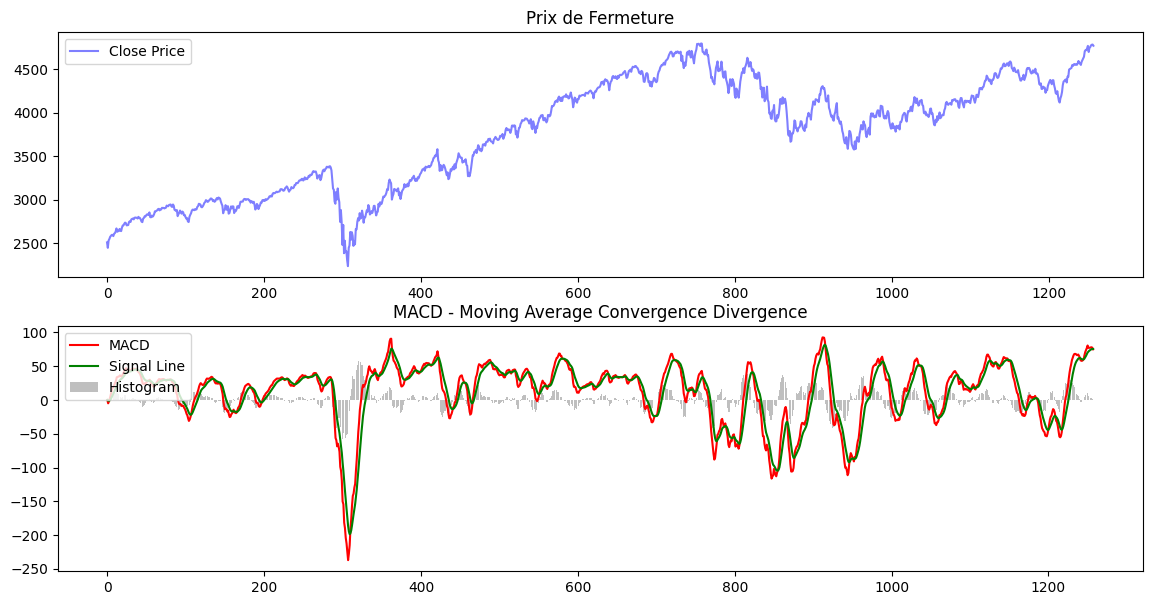

In [196]:
# Calcul des moyennes mobiles exponentielles
EMA_12 = data['Close'].ewm(span=12, adjust=False).mean()  # EMA rapide (12 périodes)
EMA_26 = data['Close'].ewm(span=26, adjust=False).mean()  # EMA lente (26 périodes)

# Calcul de la ligne MACD
MACD = EMA_12 - EMA_26
data['MACD'] = MACD

# Calcul de la ligne Signal
Signal = MACD.ewm(span=9, adjust=False).mean()

# Calcul de l'histogramme
Histogram = MACD - Signal

# Visualisation des résultats
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data['Close'], label='Close Price', color='blue', alpha=0.5)
plt.title('Prix de Fermeture')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(MACD, label='MACD', color='red')
plt.plot(Signal, label='Signal Line', color='green')
plt.bar(data.index, Histogram, label='Histogram', color='gray', alpha=0.5)
plt.legend(loc='upper left')
plt.title('MACD - Moving Average Convergence Divergence')
plt.show()

# Partie 2 : Développement du Modèle Prédictif

## Régression Linéaire

On va enlever les variables Date et Close et l'objectif sera de prédir Log_Close
Pour que le modèle prédictif soit réaliste, les prédictions sont effectuées au début de la journé et nous n'avons aucune idée des variables High, Low, Open donc on va les exclure du modèle ainsi que leur logarithmes

In [231]:
X = data.dropna().drop(['Date','Close','Log_Close','High','Low','Open','Log_High','Log_Low','Log_Open'],axis=1)
y = data.dropna()['Log_Close']

Encodage de la variable catégorique Day_of_week

In [232]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X['Day_of_Week_Encoded'] = label_encoder.fit_transform(X['Day_of_Week'])
X = X.drop('Day_of_Week',axis=1)

Les variables n'ont pas les mêmes échelles(ordre de grandeur) il va falloir Standardiser la matrice X

In [233]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [234]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [235]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


# Fitting the OLS model
reg_lin = sm.OLS(y_train, X_train).fit()

In [202]:
print(reg_lin.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Close   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     17.67
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           9.19e-35
Time:                        19:27:22   Log-Likelihood:                 3030.4
No. Observations:                 996   AIC:                            -6035.
Df Residuals:                     983   BIC:                            -5971.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0008    

##### Interprétation des résultats de la régression

Le modèle présente un **R²** de **0.177**, ce qui indique que seulement **17.7% de la variance** de la variable dépendante (`Log_Close`) est expliquée par les variables indépendantes du modèle. Ce résultat suggère que le modèle a une capacité explicative relativement faible et qu'il pourrait manquer des facteurs clés influençant les variations de `Log_Close`.

###### **Variables significatives :**
- Les variables ayant une **p-value < 0.05** sont considérées comme statistiquement significatives, ce qui signifie qu'elles contribuent de manière importante à expliquer les variations de `Log_Close`. Dans ce cas, les variables suivantes sont significatives :
  - `VIX` (p-value = 0.000)
  - `Log_RealGDP` (p-value = 0.000)

###### **Variables non significatives :**
- Certaines variables, comme `FedFundsRate` (p-value = 0.241), `RealGDP` (p-value = 0.787), et `Day_of_Week_Encoded` (p-value = 0.784), n'ont pas d'impact statistiquement significatif sur `Log_Close`. Ces variables n'expliquent pas de manière notable les variations de la cible dans le cadre de ce modèle.

###### **Conclusion :**
Le modèle actuel pourrait éventuellement être amélioré en supprimant les variables non significatives pour réduire le bruit.


In [203]:
# Prédictions sur le jeu de test
y_pred = reg_lin.predict(X_test.reset_index(drop=True))

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE : {mse}")
print(f"R^2 : {r2}")

MSE : 0.00019165702065363638
R^2 : 0.2519233519519918


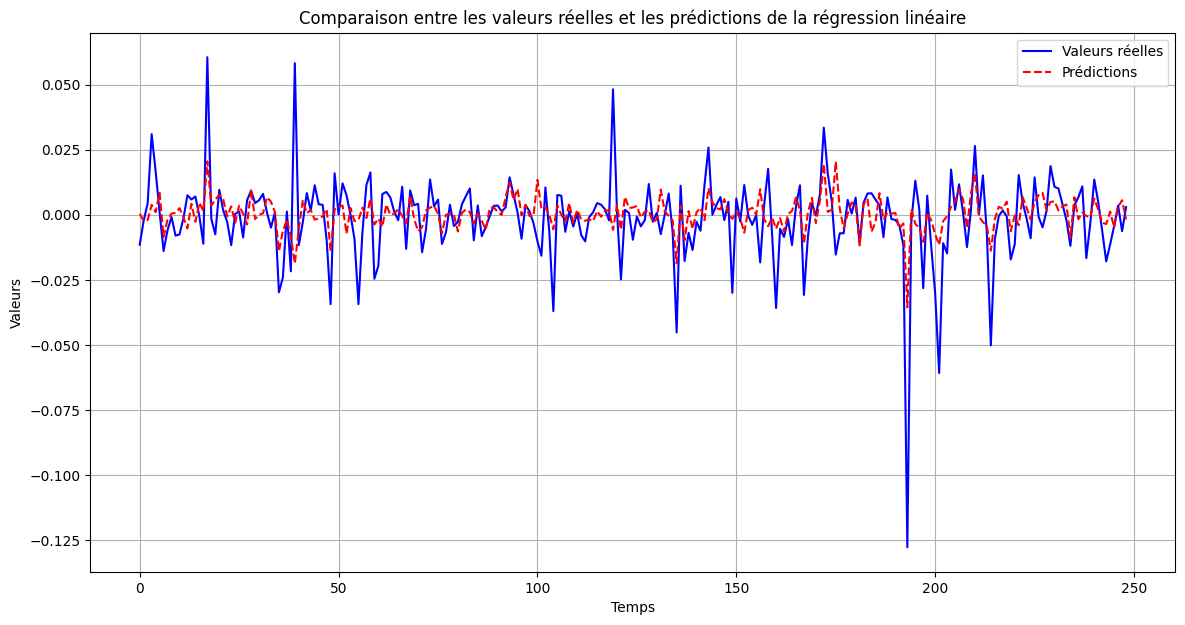

In [204]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.to_list(), label='Valeurs réelles', color='blue', linewidth=1.5)
plt.plot(y_pred.to_list(), label='Prédictions', color='red', linestyle='--', linewidth=1.5)
plt.legend()
plt.title("Comparaison entre les valeurs réelles et les prédictions de la régression linéaire")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.grid()
plt.show()

In [205]:
variables_non_significatives = ['RealGDP', 'Day_of_Month', 'Day_of_Week_Encoded']
XX_train = X_train.drop(columns=variables_non_significatives)
XX_test = X_test.drop(columns=variables_non_significatives)

In [206]:
XX_train = sm.add_constant(XX_train).reset_index(drop=True)
XX_test = sm.add_constant(XX_test).reset_index(drop=True)

In [207]:
reg_lin2 = sm.OLS(y_train, XX_train).fit()

In [208]:
reg_lin2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log_Close   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     23.60
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           9.50e-37
Time:                        19:27:23   Log-Likelihood:                 3030.2
No. Observations:                 996   AIC:                            -6040.
Df Residuals:                     986   BIC:                            -5991.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0008      0.000      2.227      0.026    9.73e-05       0.002
Volume                0.0010      0.001      1.929      0.054   -1.74e-05       0.002
VIX                  -0.0030      0.001     -4.571      0.000      -0.004      -0.002
FedFundsRate         -0.0008      0.000     -1.877      0.061      -0.002    3.54e-05
inflation            -0.0006      0.000     -1.502      0.133      -0.001       0.000
Log_RealGDP           0.0013      0.000      3.879      0.000       0.001       0.002
Month                 0.0003      0.000      0.753      0.452      -0.000       0.001
10_Day_Moving_Avg     0.0056      0.001     10.584      0.000       0.005       0.007
RSI                   0.0009      0.001      1.586      0.113      -0.000       0.002
MACD                 -0.0052      0.001     -8.567      0.000      -0.006      -0.004
==============================================================================
Omnibus:                      300.907   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6248.965
Skew:                           0.857   Prob(JB):                         0.00
Kurtosis:                      15.151   Cond. No.                         3.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
# Prédictions sur le jeu de test
y_pred2 = reg_lin2.predict(XX_test)

mse = mean_squared_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)

print(f"MSE : {mse}")
print(f"R^2 : {r2}")

MSE : 0.0001917006409572575
R^2 : 0.25175309296326054


Pas d'amélioration

## Modèle ARIMA

Vu que la série Log_Close est déjà stationnaire alors d=0
On va chercher p et q via la fonction auto_arima

In [210]:
from pmdarima import auto_arima

# Utilisation d'auto_arima pour trouver les meilleurs paramètres
model = auto_arima(
    data['Log_Close'].dropna(),
    start_p=1, max_p=10,                    # Recherche pour p entre 1 et 10 (lags)
    start_q=0, max_q=10,                     # Recherche pour q entre 1 et 5
    d=0,                                    # Série supposée stationnaire (pas de différenciation nécessaire)
    seasonal=False,
    stepwise=True,                          # Recherche pas à pas pour optimiser la vitesse
    trace=True                              # Afficher les résultats des tests
)

print("Meilleurs paramètres (p, d, q):", model.order)


Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7297.524, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7254.875, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7289.151, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-7308.544, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-7306.876, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7306.414, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7301.283, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-7304.648, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7308.731, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7298.197, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-7307.005, Time=0.59 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7306.634, Time=0.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7304.037, Time=0.73 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7304.792, Time=0.46 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 4.429 seconds
Meilleurs paramètres (p, d, q): (2, 0, 0)


**Best model:**  ARIMA(2,0,0)

**Meilleurs paramètres** (p, d, q): (2, 0, 0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


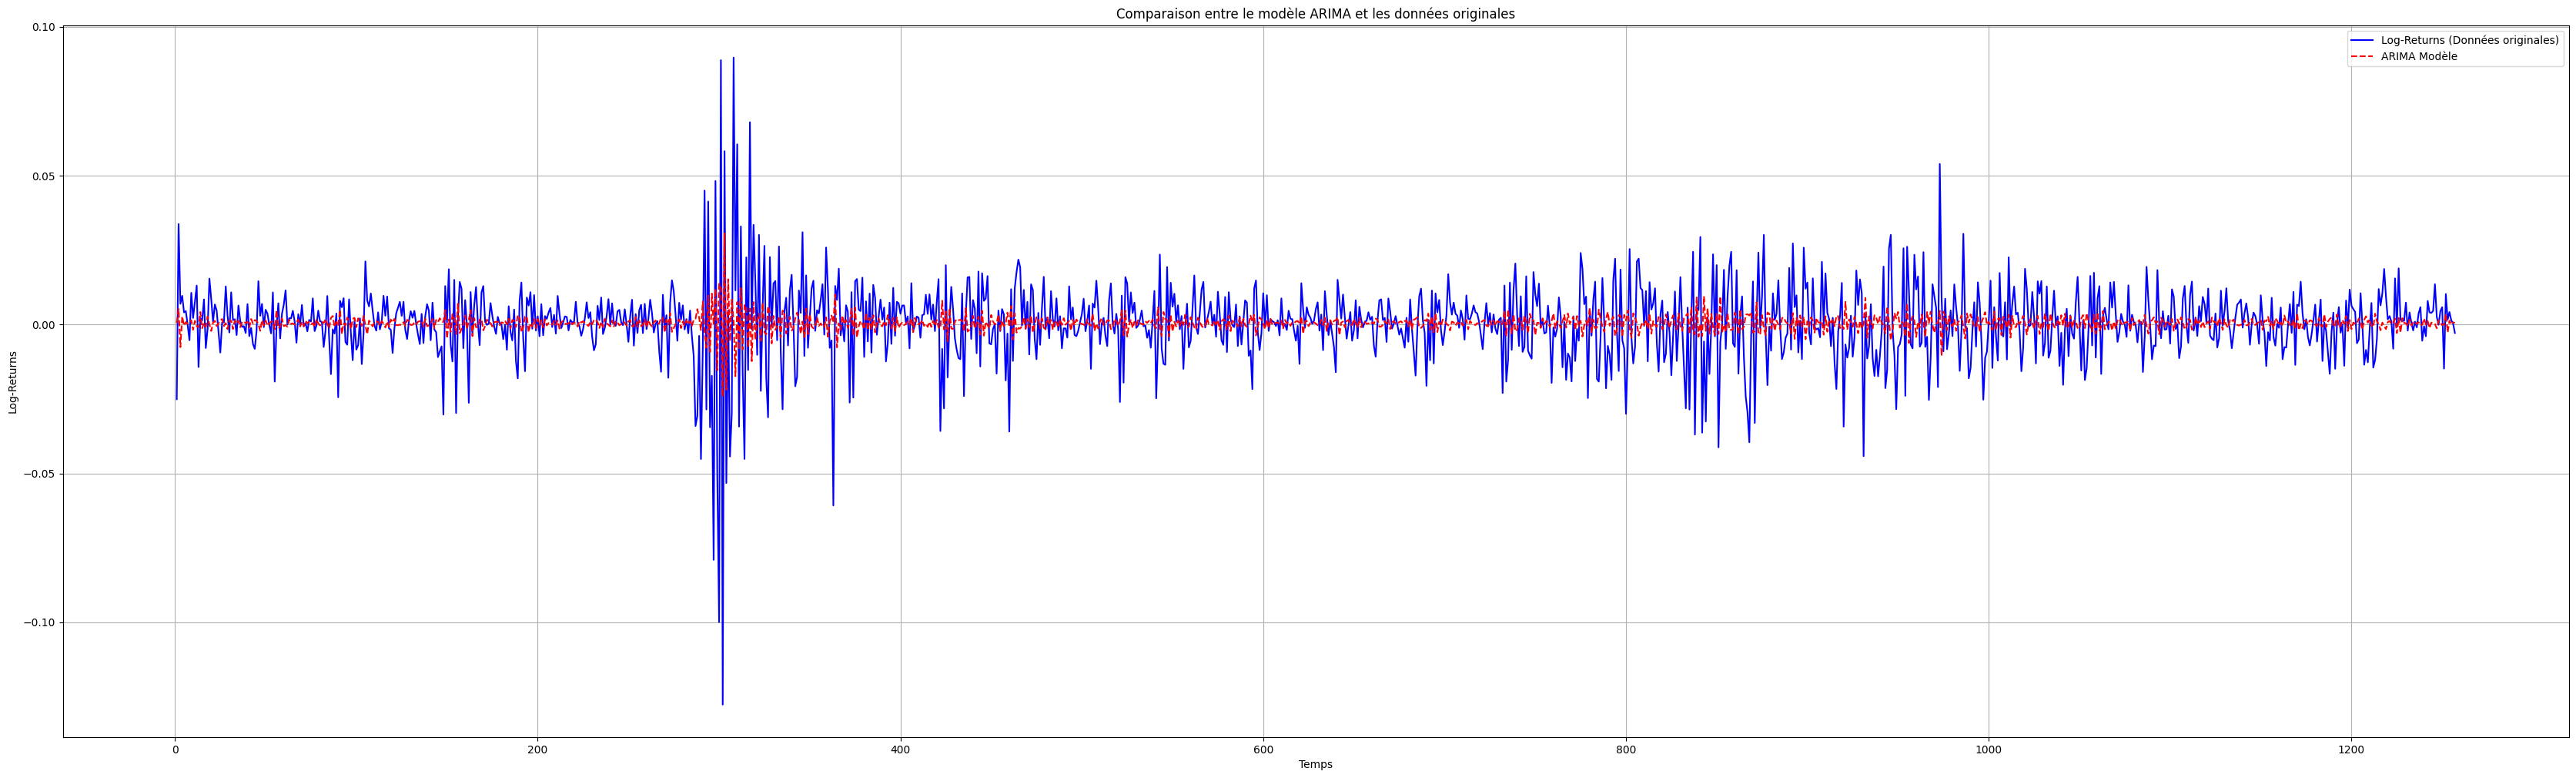

In [211]:
# le modèle ARIMA
model = ARIMA(data['Log_Close'].dropna(), order=(2, 0, 0))
results = model.fit()

plt.figure(figsize=(42, 12))
plt.plot(data['Log_Close'].dropna(), label='Log-Returns (Données originales)', color='blue', linewidth=1.5)
plt.plot(results.fittedvalues, label='ARIMA Modèle', color='red', linestyle='--', linewidth=1.5)
plt.legend()
plt.title("Comparaison entre le modèle ARIMA et les données originales")
plt.xlabel("Temps")
plt.ylabel("Log-Returns")
plt.grid()
plt.show()


## Random Forest

In [236]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred_rf)
print(f"R^2 : {r2}")

R^2 : 0.1359946097686454


### validation croisée (n_estimators)

In [237]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid={'n_estimators': np.arange(10, 100, 5)},  # Nombre d'estimateurs
    scoring='r2',  # R² comme métrique
    cv=5           # Validation croisée à 5 folds
)

grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 95}
0.04502058566756362


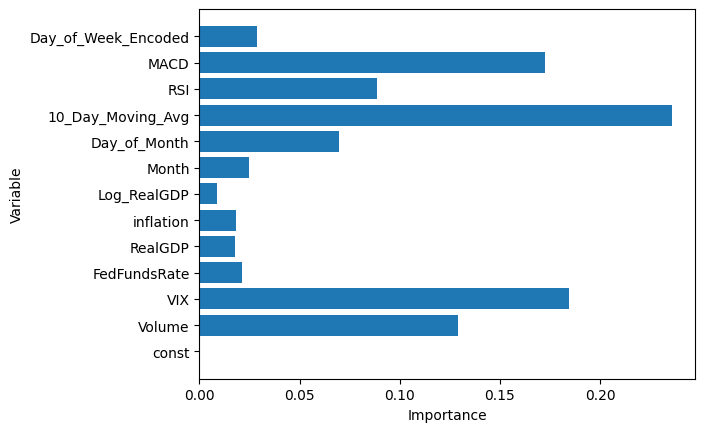

In [214]:
grid.best_estimator_.feature_importances_
plt.barh(X_train.columns, grid.best_estimator_.feature_importances_)
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()

Les variables MACD, RSI, 10 days moving avr, VIX et volume sont les plus à expliquer la target

## Gradient Boosting

In [215]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
r2 = r2_score(y_test, y_pred_gb)
print(f"R^2 : {r2}")

R^2 : -0.02452678743365455


### validation croisée (n_estimators)

In [238]:
grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid={'n_estimators': np.arange(10, 100, 5)},  # Nombre d'estimateurs
    scoring='r2',  # R² comme métrique
    cv=5           # Validation croisée à 5 folds
)

grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 25}
0.11490294993143231


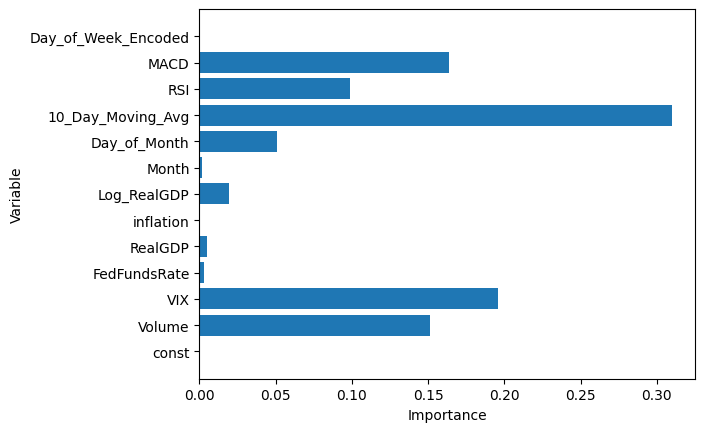

In [217]:
grid.best_estimator_.feature_importances_
plt.barh(X_train.columns, grid.best_estimator_.feature_importances_)
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()

## LSTM (Long Short-Term Memory)

In [240]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

données = data['Log_Close'].dropna().values.reshape(-1, 1)

In [241]:
# Normalisation des données
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(données)

# Création des séquences pour LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Longueur des séquences
X, y = create_sequences(data_scaled, seq_length)


In [242]:

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# le modèle séquentiel LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])


model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16, verbose=1)

# Prédictions sur l'ensemble de test
predictions = model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2381 - val_loss: 0.0022
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_l

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


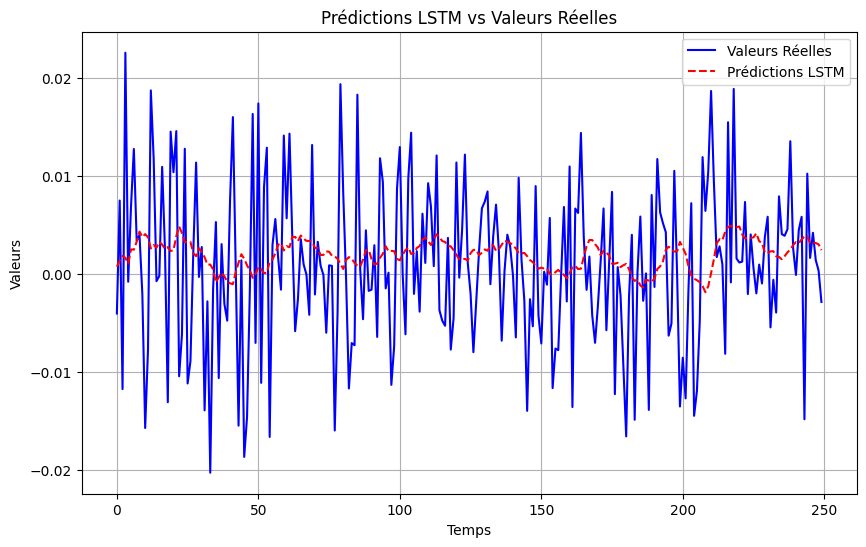

In [244]:
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_rescaled = scaler.inverse_transform(predictions)

# Visualisation des résultats

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Valeurs Réelles', color='blue')
plt.plot(predictions_rescaled, label='Prédictions LSTM', color='red', linestyle='--')
plt.legend()
plt.title('Prédictions LSTM vs Valeurs Réelles')
plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.grid()
plt.show()


In [222]:
r2 = r2_score(y_test_rescaled, predictions_rescaled)
print(f"R^2 : {r2}")

R^2 : -0.2580384768710322


# Pipeline

### Étape 1 : Chargement et préparation des données

In [223]:
def load_and_prepare_data():
    #GSPC
    sp500 = yf.download('^GSPC', start='2019-01-01', end='2024-01-01', interval='1d')
    sp500.columns = [col[0] for col in sp500.columns]
    sp500 = sp500.reset_index()

    #VIX
    vix = yf.download('^VIX', start='2019-01-01', end='2024-01-01', interval='1d')
    vix = vix[['Close']].rename(columns={'Close': 'VIX'})
    vix.columns = [col[0] for col in vix.columns]
    vix = vix.reset_index()

    #Fed Funds Rate
    fred = Fred(api_key='bf789efaf2de29f1410841d297296d31')
    rates = fred.get_series('FEDFUNDS', observation_start='2019-01-02', observation_end='2023-12-29')
    rates_df = rates.reset_index()
    rates_df.columns = ['Date', 'FedFundsRate']
    rates_df = rates_df.set_index('Date').resample('D').ffill()
    Date = sp500['Date'].copy()
    rates_df = pd.merge(Date, rates_df, on='Date', how='left').fillna(5.33)

    #inflation
    api_key = '2669IYGNWWU73XGL'
    url = f'https://www.alphavantage.co/query?function=INFLATION&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    inflation_data = pd.DataFrame.from_dict(data['data'])
    inflation_data['date'] = pd.to_datetime(inflation_data['date'])
    inflation_data = inflation_data.rename(columns={'date':'Date','value':'inflation'})
    inflation_data = inflation_data.iloc[:5,:]
    inflation_data = inflation_data.set_index('Date').resample('D').ffill()
    inflation_data = pd.merge(Date, inflation_data, on='Date', how='left').fillna(4.11633838374488)

    #PIB

    gdp_data = fred.get_series('GDPC1', observation_start='2019-01-02',observation_end='2023-12-29')
    gdp_df = gdp_data.reset_index()
    gdp_df.columns = ['Date', 'RealGDP']
    new_row = pd.DataFrame({'Date': ['2023-12-29'], 'RealGDP': [22960.600]})
    df = pd.concat([gdp_df, new_row], ignore_index=True)
    df['Date'] = pd.to_datetime(df['Date'])
    gdp_df = df.sort_values(by='Date').reset_index(drop=True)
    gdp_df = gdp_df.set_index('Date').resample('D').ffill()

    #Jointure
    merged_df = sp500.merge(vix, on='Date', how='left')
    merged_df = merged_df.merge(rates_df, on='Date', how='left')
    merged_df = merged_df.merge(gdp_df, on='Date', how='left')
    data = merged_df.merge(inflation_data, on='Date', how='left')

    return data


### Étape 2 : Préparation des features et de la cible

In [224]:
def prepare_features_and_target(data):
      #  Rendements log
      data['Log_Close'] = np.log(data['Close'] / data['Close'].shift(1))
      data['Log_High'] = np.log(data['High'] / data['High'].shift(1))
      data['Log_Low'] = np.log(data['Low'] / data['Low'].shift(1))
      data['Log_Open'] = np.log(data['Open'] / data['Open'].shift(1))
      data['Log_RealGDP'] = np.log(data['RealGDP'] / data['RealGDP'].shift(1))

      # Variables temporelles
      data['Month'] = data['Date'].dt.month
      data['Day_of_Week'] = data['Date'].dt.day_name()
      data['Day_of_Month'] = data['Date'].dt.day

      # Moyenne mobile sur 10 jours
      data['10_Day_Moving_Avg'] = data['Log_Close'].rolling(window=10).mean()

      # RSI
      Delta = data['Close'].diff()
      Gain = Delta.apply(lambda x: x if x > 0 else 0)
      Loss = Delta.apply(lambda x: -x if x < 0 else 0)
      N = 14
      Avg_Gain = Gain.rolling(window=N).mean()
      Avg_Loss = Loss.rolling(window=N).mean()
      RS = Avg_Gain / Avg_Loss
      data['RSI'] = 100 - (100 / (1 + RS))

      # MACD
      EMA_12 = data['Close'].ewm(span=12, adjust=False).mean()  # EMA rapide (12 périodes)
      EMA_26 = data['Close'].ewm(span=26, adjust=False).mean()  # EMA lente (26 périodes)
      MACD = EMA_12 - EMA_26
      data['MACD'] = MACD

      # Enlever quelques variables
      X = data.dropna().drop(['Date','Adj Close','Close','Log_Close','High','Low','Open','Log_High','Log_Low','Log_Open'],axis=1)
      y = data.dropna()['Log_Close']

      return X, y

### Étape 3 : Encodage des variables catégoriques

In [225]:
def encoded_data(X):
    X = X[0]
    label_encoder = LabelEncoder()
    X['Day_of_Week_Encoded'] = label_encoder.fit_transform(X['Day_of_Week'])
    X = X.drop('Day_of_Week',axis=1)
    return X

### Étape 4 : Standardisation de X

In [226]:
def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    return X

### Étape 5 : Entraînement du modèle

In [227]:
def train_model(X_train, y_train):
      X_train = sm.add_constant(X_train).reset_index(drop=True)
      y_train = y_train.reset_index(drop=True)
      # Fitting the OLS model
      reg_lin = sm.OLS(y_train, X_train).fit()
      return reg_lin

### Étape 6 : Pipeline complète


In [228]:
def pipeline():
    data = prepare_features_and_target(load_and_prepare_data())
    y = data[1]
    X = encoded_data(data)
    X = standardize_data(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    model = train_model(X_train, y_train)

    return model.summary()

In [229]:
pipeline()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log_Close   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     17.67
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           9.19e-35
Time:                        19:28:27   Log-Likelihood:                 3030.4
No. Observations:                 996   AIC:                            -6035.
Df Residuals:                     983   BIC:                            -5971.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0008      0.000      2.223      0.026     9.6e-05       0.002
Volume                  0.0010      0.001      1.940      0.053   -1.16e-05       0.002
VIX                    -0.0030      0.001     -4.435      0.000      -0.004      -0.002
FedFundsRate           -0.0007      0.001     -1.174      0.241      -0.002       0.000
RealGDP                -0.0002      0.001     -0.270      0.787      -0.002       0.001
inflation              -0.0005      0.001     -0.723      0.470      -0.002       0.001
Log_RealGDP             0.0013      0.000      3.884      0.000       0.001       0.002
Month                   0.0003      0.000      0.805      0.421      -0.000       0.001
Day_of_Month            0.0001      0.000      0.274      0.784      -0.001       0.001
10_Day_Moving_Avg       0.0056      0.001     10.391      0.000       0.005       0.007
RSI                     0.0009      0.001      1.572      0.116      -0.000       0.002
MACD                   -0.0052      0.001     -8.537      0.000      -0.006      -0.004
Day_of_Week_Encoded    -0.0001      0.000     -0.274      0.784      -0.001       0.001
==============================================================================
Omnibus:                      302.683   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6276.921
Skew:                           0.866   Prob(JB):                         0.00
Kurtosis:                      15.176   Cond. No.                         5.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""